# This is the notebook, that loads the data and trains the specified model, and visualizes the results

## Predicting All at Once

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('../TrainingData/trainingdata23.csv')

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history for predictions six months
output_sequence_length = 24  # Predict the next 24 hours

# Prepare the input features and target prices
X, y = [], []

for i in range(len(data) - sequence_length - output_sequence_length):
    # Use 'Price1' and any other relevant features you have added
    # These are the features that the model will use to make predictions: Year,Month,Day,Hour,Price1,Hour_Sin,Hour_Cos,Day_Sin,Day_Cos,Month_Sin,Month_Cos,Year_Scaled,Price2
    features = data[['Price1','Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values
    X.append(features[i:i + sequence_length])  # input sequence
    y.append(features[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # output sequence of prices

X = np.array(X)  # Shape: (samples, sequence_length, features)
y = np.array(y)  # Shape: (samples, output_sequence_length)

# Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_shape = X.shape
X = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X_shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Build the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=output_sequence_length)  # Output layer for sequence prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 50  # Adjust based on your needs
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')


/home/teitur/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-22 15:28:19.528826: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50577408 exceeds 10% of free system memory.


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0764 - val_loss: 0.0288
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0296 - val_loss: 0.0262
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0266 - val_loss: 0.0256
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0244 - val_loss: 0.0248
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0232 - val_loss: 0.0247
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0223 - val_loss: 0.0252
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0204 - val_loss: 0.0241
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0196 - val_loss: 0.0249
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0190 - val_loss: 0.0240
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0190 - val_loss: 0.0237
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
### Visualization of Predictions ###
Best Performance (Index: 1322) - Deviation (x): 144.20, Deviation (x^2): 1276.24


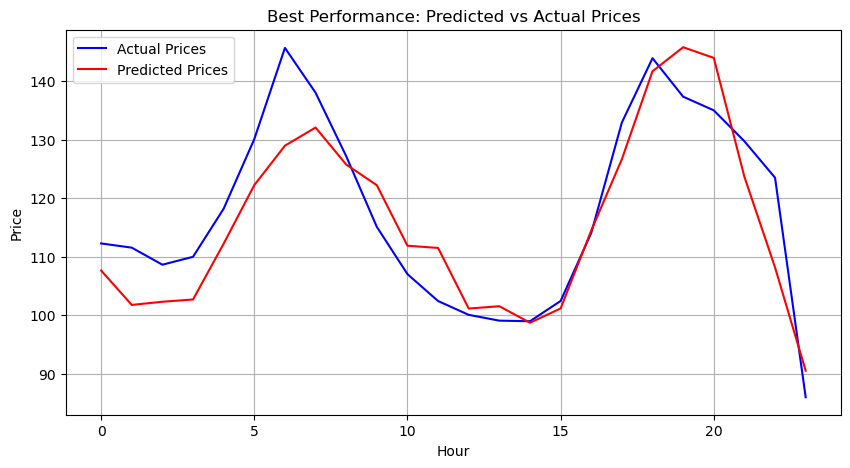

Worst Performance (Index: 385) - Deviation (x): 2803.93, Deviation (x^2): 330192.48


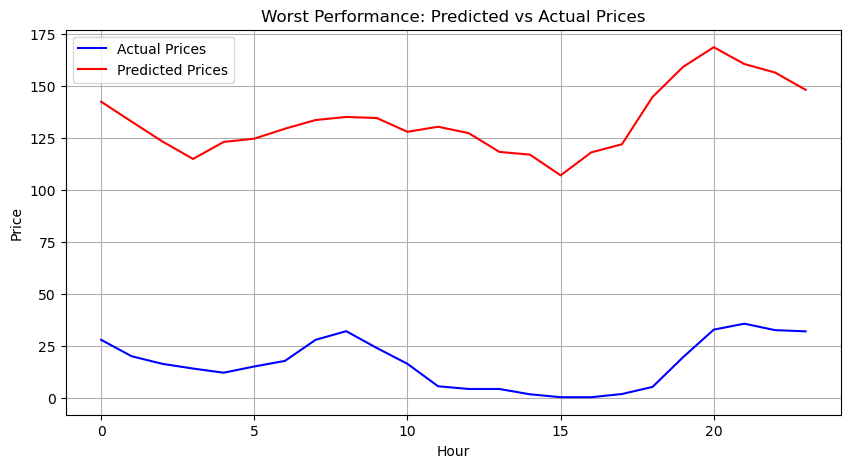

Median Performance (Index: 1182) - Deviation (x): 771.97, Deviation (x^2): 39792.45


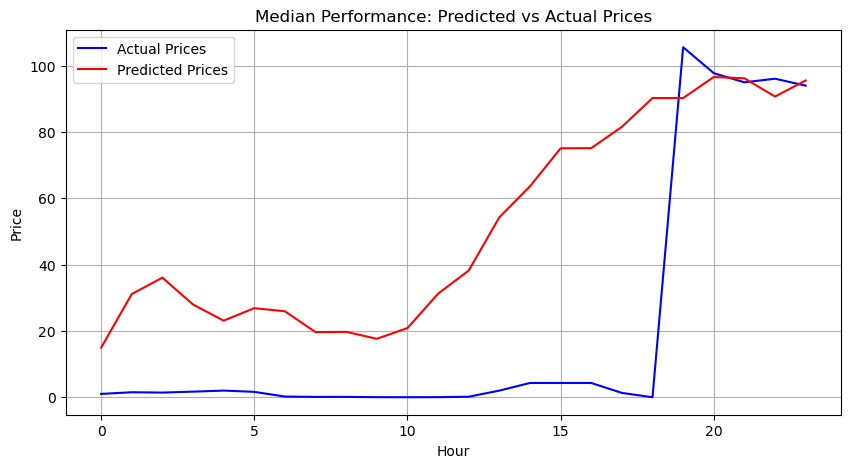

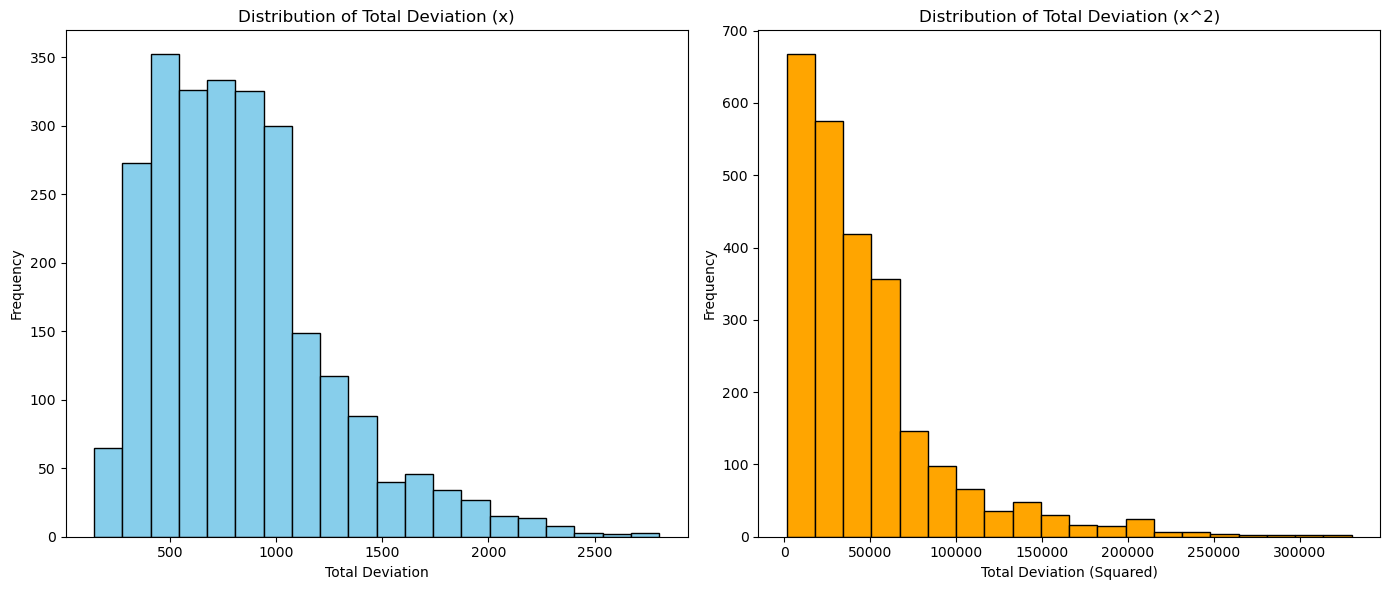


### Deviation Summary ###
Average Deviation (x): 836.01
Average Deviation (x^2): 47602.89
Maximum Deviation (x): 2803.93
Maximum Deviation (x^2): 330192.48
Minimum Deviation (x): 144.20
Minimum Deviation (x^2): 1276.24


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate deviation metrics
deviation_x = np.abs(y_test_pred - y_test_actual)  # Absolute deviation
deviation_x2 = deviation_x ** 2  # Squared deviation

# Calculate total deviation for each example (sum across the 24-hour predictions)
total_deviation_x = deviation_x.sum(axis=1)
total_deviation_x2 = deviation_x2.sum(axis=1)

# Find indices for best, median, and worst performance
best_index = np.argmin(total_deviation_x)
worst_index = np.argmax(total_deviation_x)
median_index = np.argsort(total_deviation_x)[len(total_deviation_x) // 2]

# Function to visualize a single prediction vs. actual
def plot_prediction(index, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[index], label="Actual Prices", color="blue")
    plt.plot(y_test_pred[index], label="Predicted Prices", color="red")
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - Deviation (x): {total_deviation_x[best_index]:.2f}, Deviation (x^2): {total_deviation_x2[best_index]:.2f}")
plot_prediction(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - Deviation (x): {total_deviation_x[worst_index]:.2f}, Deviation (x^2): {total_deviation_x2[worst_index]:.2f}")
plot_prediction(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - Deviation (x): {total_deviation_x[median_index]:.2f}, Deviation (x^2): {total_deviation_x2[median_index]:.2f}")
plot_prediction(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of deviations
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(total_deviation_x, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Total Deviation (x)")
plt.xlabel("Total Deviation")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(total_deviation_x2, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of Total Deviation (x^2)")
plt.xlabel("Total Deviation (Squared)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Summary of deviations
print("\n### Deviation Summary ###")
print(f"Average Deviation (x): {np.mean(total_deviation_x):.2f}")
print(f"Average Deviation (x^2): {np.mean(total_deviation_x2):.2f}")
print(f"Maximum Deviation (x): {np.max(total_deviation_x):.2f}")
print(f"Maximum Deviation (x^2): {np.max(total_deviation_x2):.2f}")
print(f"Minimum Deviation (x): {np.min(total_deviation_x):.2f}")
print(f"Minimum Deviation (x^2): {np.min(total_deviation_x2):.2f}")









# Predicting One at a time ;)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('../TrainingData/trainingdata23.csv')

# Define input sequence length
sequence_length = 336  # Use 2 weeks of history for predictions

# Prepare the input features and target prices
X, y = [], []

for i in range(len(data) - sequence_length - 1):  # Predict one step at a time
    features = data[['Price1', 'Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values
    X.append(features[i:i + sequence_length])  # input sequence
    y.append(features[i + sequence_length, 0])  # output: the next price (Price1)

X = np.array(X)  # Shape: (samples, sequence_length, features)
y = np.array(y)  # Shape: (samples,)

# Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_shape = X.shape
X = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X_shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Build the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)  # Output layer for single-step prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 50  # Adjust based on your needs
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


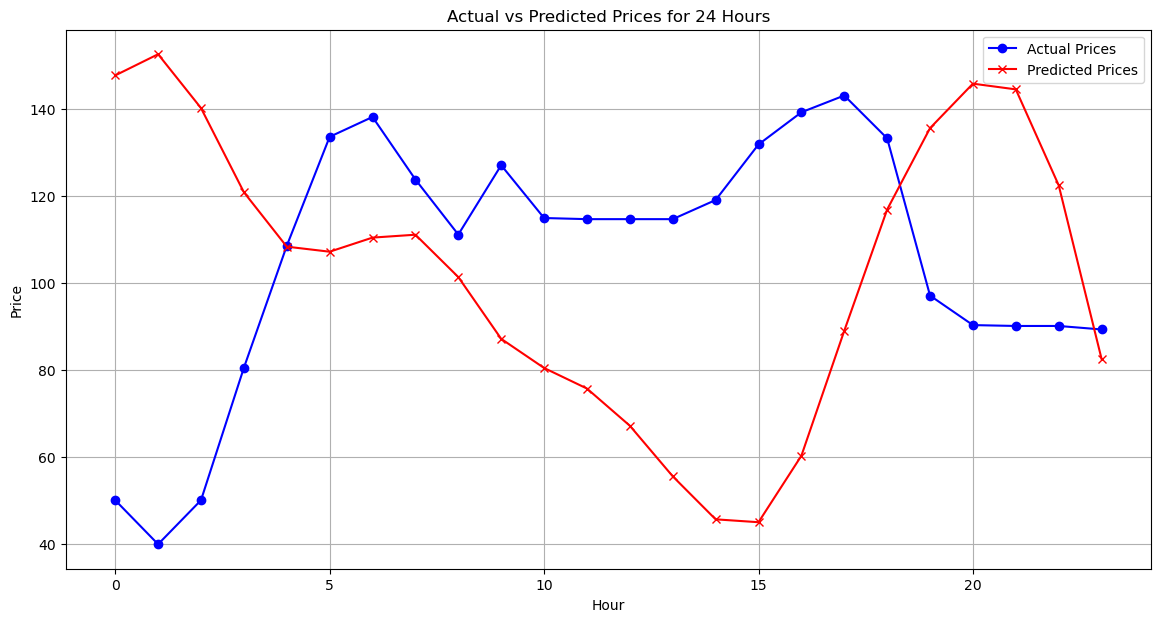

In [15]:
def predict_24_hours(model, initial_input, scaler_X, scaler_y, start_hour=0, start_day=1, start_month=1):
    input_seq = initial_input.copy()  # Start with the last known sequence
    predictions = []
    current_hour = start_hour
    current_day = start_day
    current_month = start_month

    for _ in range(24):  # Predict 24 hours
        # Predict the next value
        next_price = model.predict(input_seq[np.newaxis, :, :])[0, 0]
        predictions.append(next_price)

        # Update time features (Hour, Day, Month)
        current_hour += 1
        if current_hour == 24:  # Update day and month when hour rolls over
            current_hour = 0
            current_day += 1
            # Assuming all months have 30 days for simplicity; update as needed
            if current_day > 30:
                current_day = 1
                current_month += 1
                if current_month > 12:
                    current_month = 1

        # Calculate updated time features
        hour_sin = np.sin(2 * np.pi * current_hour / 24)
        hour_cos = np.cos(2 * np.pi * current_hour / 24)
        day_sin = np.sin(2 * np.pi * current_day / 31)
        day_cos = np.cos(2 * np.pi * current_day / 31)
        month_sin = np.sin(2 * np.pi * current_month / 12)
        month_cos = np.cos(2 * np.pi * current_month / 12)

        # Update the input sequence with the new prediction and time features
        next_features = input_seq[1:]  # Remove the oldest feature
        updated_row = input_seq[-1].copy()  # Copy the last row to modify specific fields
        updated_row[0] = next_price  # Update `Price1` with the predicted value
        updated_row[2:] = [hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos]  # Update time features
        next_features = np.vstack([next_features, updated_row])  # Append the updated row

        input_seq = next_features

    # Inverse scale predictions
    return scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()



# Test the prediction loop
initial_input = X_test[28]  # Use the first test sequence
predicted_prices = predict_24_hours(
    model, 
    initial_input, 
    scaler_X, 
    scaler_y, 
    start_hour=0,  # Starting hour of the sequence
    start_day=1,   # Starting day of the sequence
    start_month=1  # Starting month of the sequence
)

# Compare with actual prices
actual_prices = scaler_y.inverse_transform(y_test[:24].reshape(-1, 1)).flatten()

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(range(24), actual_prices, label="Actual Prices", marker='o', color='blue')
plt.plot(range(24), predicted_prices, label="Predicted Prices", marker='x', color='red')
plt.title("Actual vs Predicted Prices for 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Helper function to encode time as sine and cosine
def encode_time(value, max_value):
    sin = np.sin(2 * np.pi * value / max_value)
    cos = np.cos(2 * np.pi * value / max_value)
    return sin, cos

# Load the data
data = pd.read_csv('../TrainingData/trainingdata23.csv')

# Define input sequence length
sequence_length = 336  # Use 2 weeks of history for predictions

# Prepare the input features and target prices
X, y = [], []

for i in range(len(data) - sequence_length - 1):  # Predict one step at a time
    features = data[['Price1', 'Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values
    X.append(features[i:i + sequence_length])  # input sequence
    y.append(features[i + sequence_length, 0])  # output: the next price (Price1)

X = np.array(X)  # Shape: (samples, sequence_length, features)
y = np.array(y)  # Shape: (samples,)

# Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_shape = X.shape
X = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X_shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Build the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)  # Output layer for single-step prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 50  # Adjust based on your needs
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

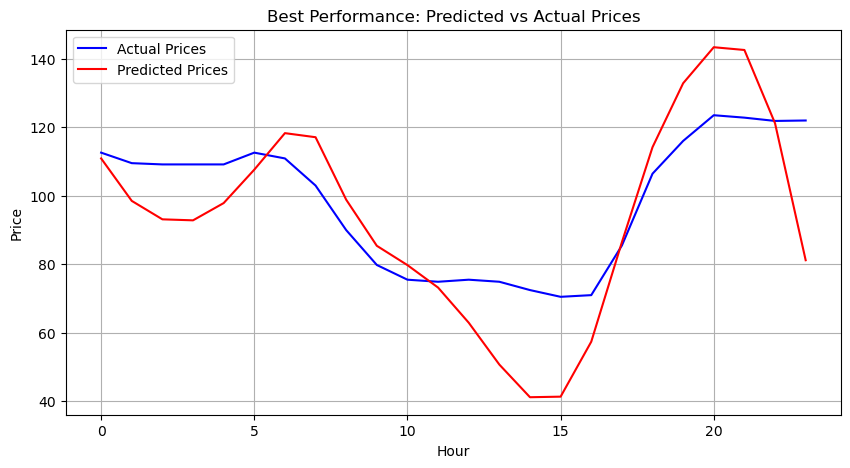

Worst Performance (Index: 49) - Deviation (x): 1457.92, Deviation (x^2): 109247.63


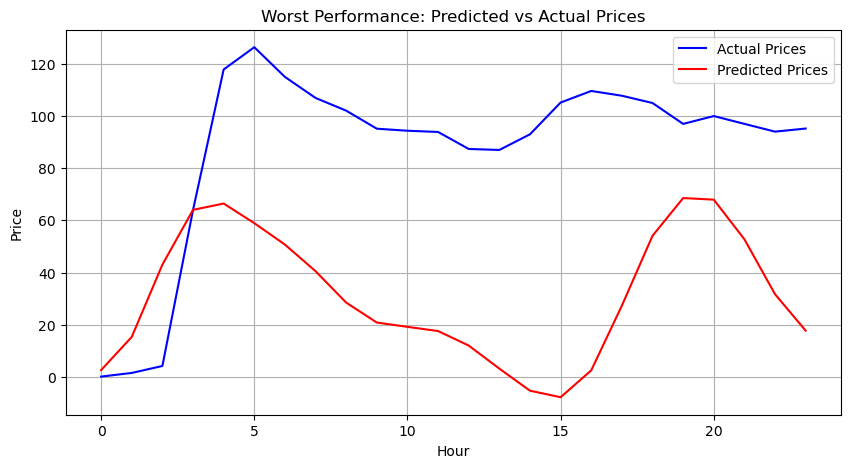

Median Performance (Index: 36) - Deviation (x): 836.45, Deviation (x^2): 44326.21


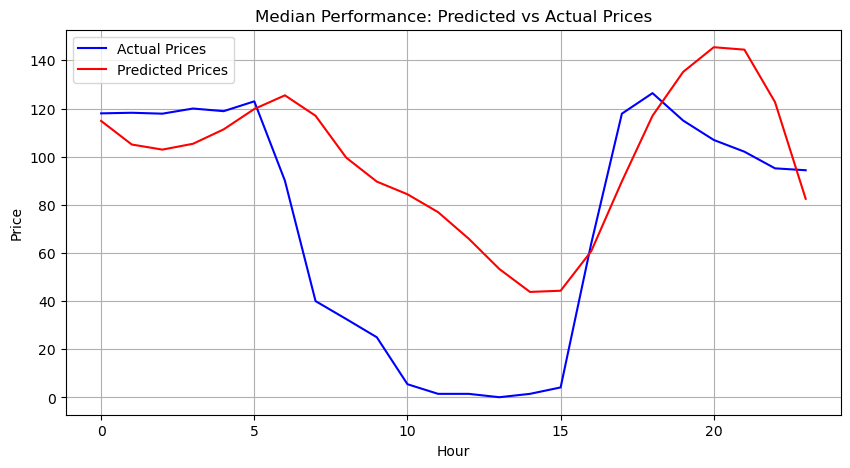

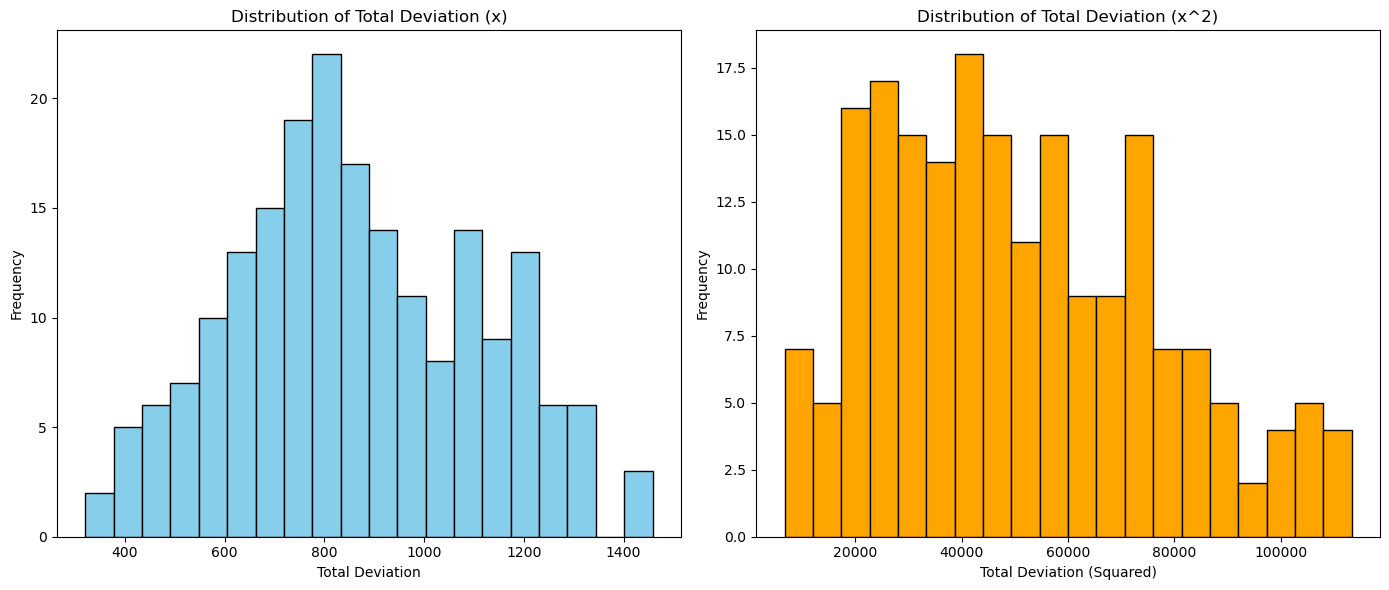


### Deviation Summary ###
Average Deviation (x): 863.04
Average Deviation (x^2): 50864.28
Maximum Deviation (x): 1457.92
Maximum Deviation (x^2): 113309.39
Minimum Deviation (x): 320.78
Minimum Deviation (x^2): 6739.39


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prediction loop using predict_24_hours
num_samples = len(X_test)
predictions = []
actuals = []

# Updated Prediction Loop for 24 Hours
def predict_24_hours(model, initial_input, scaler_X, scaler_y, start_hour=0, start_day=1, start_month=1):
    input_seq = initial_input.copy()  # Start with the last known sequence
    predictions = []
    current_hour = start_hour
    current_day = start_day
    current_month = start_month

    for _ in range(24):  # Predict 24 hours
        # Predict the next value
        next_price = model.predict(input_seq[np.newaxis, :, :])[0, 0]
        predictions.append(next_price)

        # Update time features (Hour, Day, Month)
        current_hour += 1
        if current_hour == 24:  # Update day and month when hour rolls over
            current_hour = 0
            current_day += 1
            if current_day > 30:  # Assuming all months have 30 days for simplicity
                current_day = 1
                current_month += 1
                if current_month > 12:
                    current_month = 1

        # Calculate updated time features
        hour_sin = np.sin(2 * np.pi * current_hour / 24)
        hour_cos = np.cos(2 * np.pi * current_hour / 24)
        day_sin = np.sin(2 * np.pi * current_day / 31)
        day_cos = np.cos(2 * np.pi * current_day / 31)
        month_sin = np.sin(2 * np.pi * current_month / 12)
        month_cos = np.cos(2 * np.pi * current_month / 12)

        # Update the input sequence with the new prediction and time features
        next_features = input_seq[1:]  # Remove the oldest feature
        updated_row = input_seq[-1].copy()  # Copy the last row to modify specific fields
        updated_row[0] = next_price  # Update `Price1` with the predicted value
        updated_row[2:] = [hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos]  # Update time features
        next_features = np.vstack([next_features, updated_row])  # Append the updated row

        input_seq = next_features

    # Convert predictions to a 2D array with shape (24, 1) before applying scaler
    predictions = np.array(predictions).reshape(-1, 1)

    # Inverse scale predictions
    return scaler_y.inverse_transform(predictions).flatten()


# Use predict_24_hours to generate predictions for each sample in the test set
for i in range(200):  # Adjust range for more samples if desired
    initial_input = X_test[i]  # Use the current test sequence as input
    predicted_prices = predict_24_hours(
        model, 
        initial_input, 
        scaler_X, 
        scaler_y, 
        start_hour=0,  # Starting hour of the sequence
        start_day=1,   # Starting day of the sequence
        start_month=1  # Starting month of the sequence
    )
    predictions.append(predicted_prices)

    # Get the corresponding actual prices for comparison
    actual_prices = scaler_y.inverse_transform(y_test[i:i+24].reshape(-1, 1)).flatten()  # Rescale actual prices
    actuals.append(actual_prices)

# Convert predictions and actuals to arrays
y_test_pred = np.array(predictions)
y_test_actual = np.array(actuals)

# Calculate deviation metrics
deviation_x = np.abs(y_test_pred - y_test_actual)  # Absolute deviation
deviation_x2 = deviation_x ** 2  # Squared deviation

# Calculate total deviation for each example
total_deviation_x = deviation_x.sum(axis=1)
total_deviation_x2 = deviation_x2.sum(axis=1)

# Find indices for best, median, and worst performance
best_index = np.argmin(total_deviation_x)
worst_index = np.argmax(total_deviation_x)
median_index = np.argsort(total_deviation_x)[len(total_deviation_x) // 2]

# Function to visualize a single prediction vs. actual
def plot_prediction(index, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[index], label="Actual Prices", color="blue")
    plt.plot(y_test_pred[index], label="Predicted Prices", color="red")
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - Deviation (x): {total_deviation_x[best_index]:.2f}, Deviation (x^2): {total_deviation_x2[best_index]:.2f}")
plot_prediction(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - Deviation (x): {total_deviation_x[worst_index]:.2f}, Deviation (x^2): {total_deviation_x2[worst_index]:.2f}")
plot_prediction(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - Deviation (x): {total_deviation_x[median_index]:.2f}, Deviation (x^2): {total_deviation_x2[median_index]:.2f}")
plot_prediction(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of deviations
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(total_deviation_x, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Total Deviation (x)")
plt.xlabel("Total Deviation")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(total_deviation_x2, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of Total Deviation (x^2)")
plt.xlabel("Total Deviation (Squared)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Summary of deviations
print("\n### Deviation Summary ###")
print(f"Average Deviation (x): {np.mean(total_deviation_x):.2f}")
print(f"Average Deviation (x^2): {np.mean(total_deviation_x2):.2f}")
print(f"Maximum Deviation (x): {np.max(total_deviation_x):.2f}")
print(f"Maximum Deviation (x^2): {np.max(total_deviation_x2):.2f}")
print(f"Minimum Deviation (x): {np.min(total_deviation_x):.2f}")
print(f"Minimum Deviation (x^2): {np.min(total_deviation_x2):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

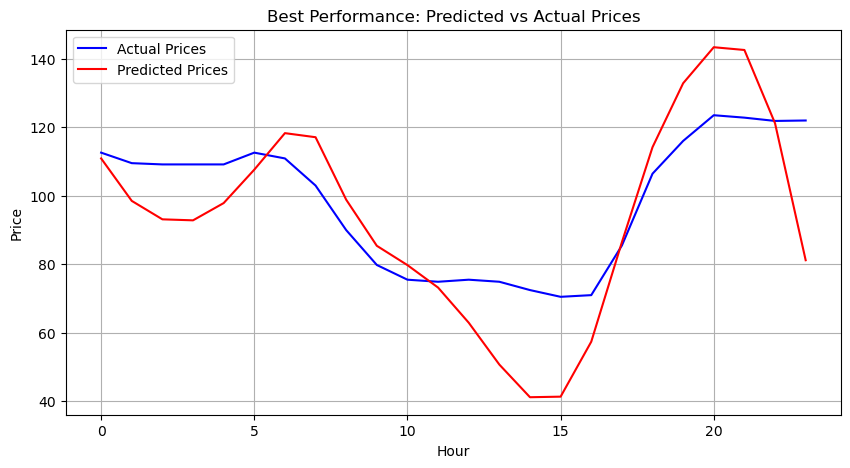

Worst Performance (Index: 345) - Deviation (x): 2319.26, Deviation (x^2): 236930.61


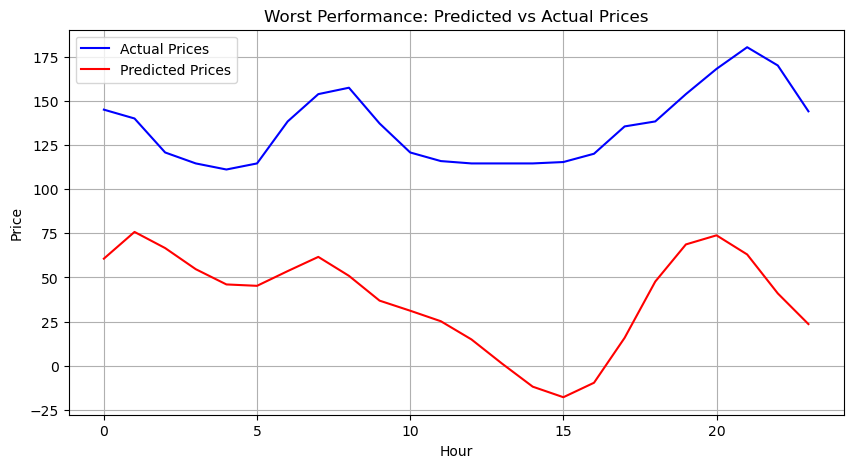

Median Performance (Index: 234) - Deviation (x): 901.89, Deviation (x^2): 51890.46


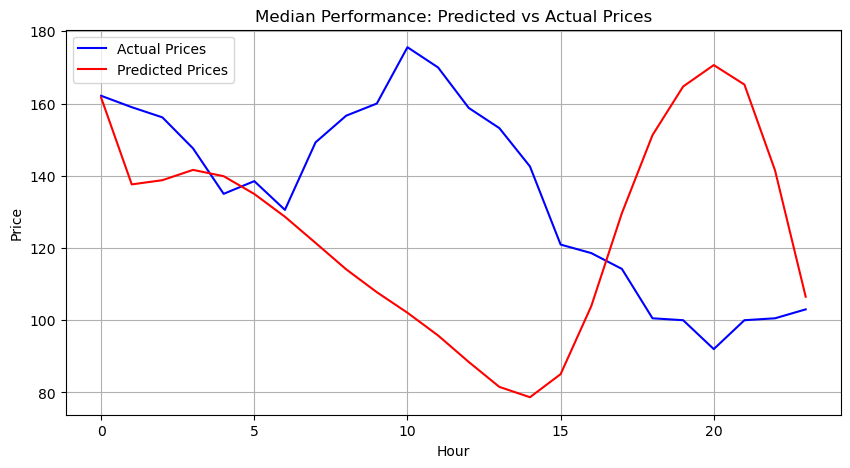

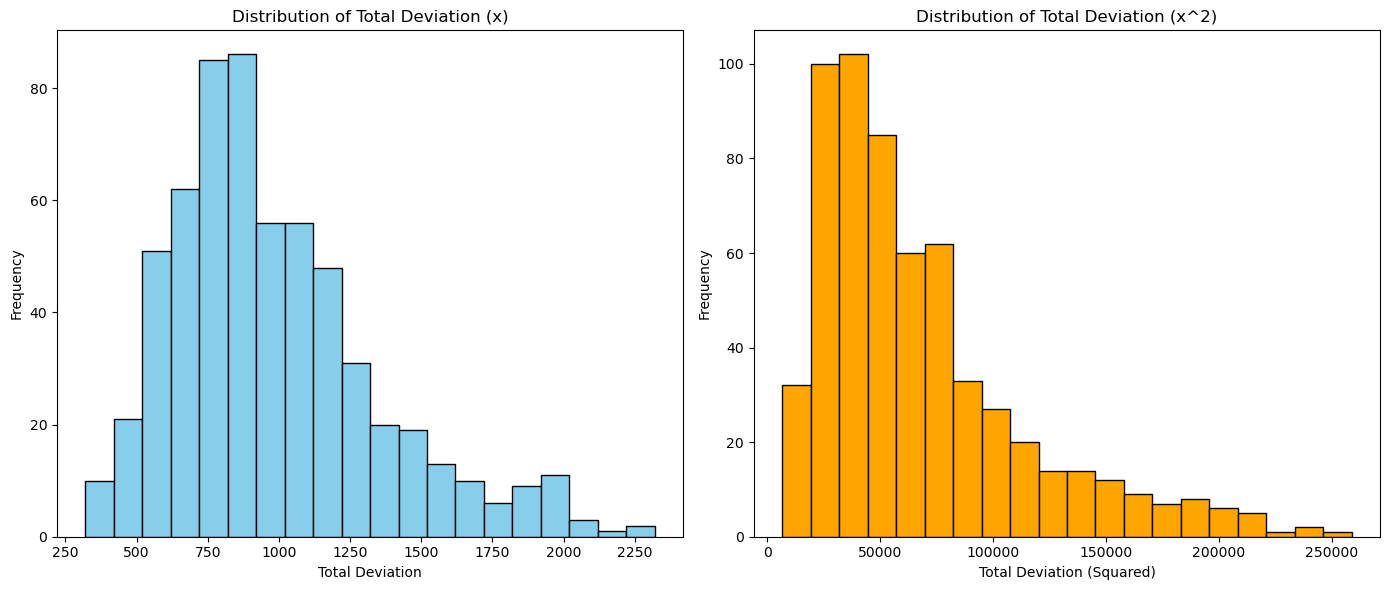


### Deviation Summary ###
Average Deviation (x): 983.70
Average Deviation (x^2): 67772.48
Maximum Deviation (x): 2319.26
Maximum Deviation (x^2): 258721.59
Minimum Deviation (x): 320.78
Minimum Deviation (x^2): 6739.39


In [21]:
# Start running predictions from where you left off
start_index = len(predictions)  # Assuming you already ran 200 samples
end_index = start_index + 400  # Run the next 400 samples

for i in range(start_index, end_index):
    initial_input = X_test[i]  # Use the current test sequence as input
    predicted_prices = predict_24_hours(
        model, 
        initial_input, 
        scaler_X, 
        scaler_y, 
        start_hour=0,  # Starting hour of the sequence
        start_day=1,   # Starting day of the sequence
        start_month=1  # Starting month of the sequence
    )
    predictions.append(predicted_prices)

    # Get the corresponding actual prices for comparison
    actual_prices = scaler_y.inverse_transform(y_test[i:i+24].reshape(-1, 1)).flatten()  # Rescale actual prices
    actuals.append(actual_prices)

# Convert predictions and actuals to arrays
y_test_pred = np.array(predictions)
y_test_actual = np.array(actuals)

# Calculate deviation metrics
deviation_x = np.abs(y_test_pred - y_test_actual)  # Absolute deviation
deviation_x2 = deviation_x ** 2  # Squared deviation

# Calculate total deviation for each example
total_deviation_x = deviation_x.sum(axis=1)
total_deviation_x2 = deviation_x2.sum(axis=1)

# Find indices for best, median, and worst performance
best_index = np.argmin(total_deviation_x)
worst_index = np.argmax(total_deviation_x)
median_index = np.argsort(total_deviation_x)[len(total_deviation_x) // 2]

# Function to visualize a single prediction vs. actual
def plot_prediction(index, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[index], label="Actual Prices", color="blue")
    plt.plot(y_test_pred[index], label="Predicted Prices", color="red")
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - Deviation (x): {total_deviation_x[best_index]:.2f}, Deviation (x^2): {total_deviation_x2[best_index]:.2f}")
plot_prediction(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - Deviation (x): {total_deviation_x[worst_index]:.2f}, Deviation (x^2): {total_deviation_x2[worst_index]:.2f}")
plot_prediction(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - Deviation (x): {total_deviation_x[median_index]:.2f}, Deviation (x^2): {total_deviation_x2[median_index]:.2f}")
plot_prediction(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of deviations
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(total_deviation_x, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Total Deviation (x)")
plt.xlabel("Total Deviation")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(total_deviation_x2, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of Total Deviation (x^2)")
plt.xlabel("Total Deviation (Squared)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Summary of deviations
print("\n### Deviation Summary ###")
print(f"Average Deviation (x): {np.mean(total_deviation_x):.2f}")
print(f"Average Deviation (x^2): {np.mean(total_deviation_x2):.2f}")
print(f"Maximum Deviation (x): {np.max(total_deviation_x):.2f}")
print(f"Maximum Deviation (x^2): {np.max(total_deviation_x2):.2f}")
print(f"Minimum Deviation (x): {np.min(total_deviation_x):.2f}")
print(f"Minimum Deviation (x^2): {np.min(total_deviation_x2):.2f}")


# Here we are using teacher forcing ( Still messing around, https://www.kaggle.com/code/kmkarakaya/part-d-encoder-decoder-with-teacher-forcing)

In [ ]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Define constants
n_features = X_train.shape[2]  # Number of input features (e.g., 8 in your case)
LSTMoutputDimension = 50      # Number of LSTM units
n_timesteps_in = X_train.shape[1]  # Sequence length for encoder input (e.g., 336)
n_timesteps_out = 24           # Number of output steps (24 hours)

# Define the encoder
encoder_inputs = Input(shape=(n_timesteps_in, n_features))
encoder_lstm = LSTM(LSTMoutputDimension, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]  # Context vector

# Define the decoder
decoder_inputs = Input(shape=(None, n_features))  # Decoder takes inputs for each time step
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation='linear')  # Predict a single output feature (price)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the training model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Ensure `y_train` is divisible by `n_timesteps_out`
n_timesteps_out = 24  # Ensure this value matches your expected output timesteps

# Calculate the maximum divisible size
max_divisible_size = (y_train.size // n_timesteps_out) * n_timesteps_out

# Truncate `y_train` to make it divisible by `n_timesteps_out`
y_train = y_train[:max_divisible_size]

# Reshape `y_train` to be (number_of_samples, n_timesteps_out)
y_train = y_train.reshape(-1, n_timesteps_out)

# Truncate `X_train` to match the number of samples in `y_train`
X_train = X_train[:y_train.shape[0]]

# Verify the shapes
print(f"Adjusted X_train shape: {X_train.shape}")
print(f"Adjusted y_train shape: {y_train.shape}")

# Prepare the decoder input data (shifted `y_train`)
decoder_input_data = np.zeros((y_train.shape[0], n_timesteps_out, n_features))
decoder_input_data[:, :, 0] = np.pad(y_train[:, :-1], ((0, 0), (1, 0)), mode='constant')

# Verify the shapes again
print(f"Decoder input data shape: {decoder_input_data.shape}")





# Train the model with teacher forcing
model.fit([X_train, decoder_input_data], y_train, batch_size=32, epochs=50, validation_split=0.2)

# Inference models
# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Function for inference with scaling applied
def decode_sequence(input_seq, scaler_y):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first feature (Price1) as the start signal
    target_seq[0, 0, 0] = input_seq[0, -1, 0]  # Use the last price in the input sequence

    # Sampling loop
    decoded_seq = []
    for _ in range(n_timesteps_out):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Save prediction (output price in normalized range)
        decoded_seq.append(output_tokens[0, 0, 0])

        # Update the target sequence (use the predicted price as the next input)
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, 0] = output_tokens[0, 0, 0]

        # Update states
        states_value = [h, c]

    # Scale the predictions back to the original range
    decoded_seq = scaler_y.inverse_transform(np.array(decoded_seq).reshape(-1, 1)).flatten()
    return decoded_seq

# Test the model
for i in range(5):
    input_seq = X_test[i:i+1]  # Single input sequence
    decoded_seq = decode_sequence(input_seq, scaler_y)  # Use scaler_y to inverse scale

    # Extract the actual sequence from `y_test`
    actual_seq = y_test[i * n_timesteps_out:(i + 1) * n_timesteps_out]  # Correct slicing
    actual_seq = scaler_y.inverse_transform(actual_seq.reshape(-1, 1)).flatten()  # Scale back

    # Print results
    print(f"Input Sequence {i+1}: {actual_seq}")
    print(f"Decoded Sequence {i+1}: {decoded_seq}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_timesteps_out), actual_seq, label="Actual Prices", marker='o')
    plt.plot(range(n_timesteps_out), decoded_seq, label="Predicted Prices", marker='x')
    plt.title(f"Actual vs Predicted Prices (Sequence {i+1})")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

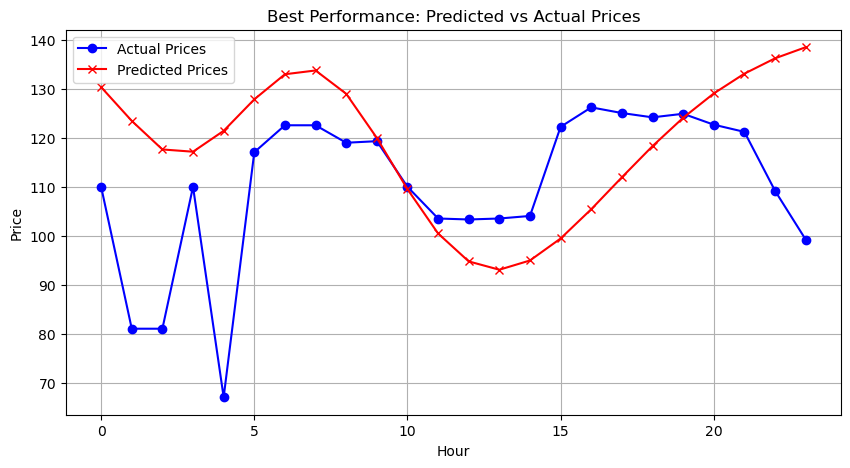

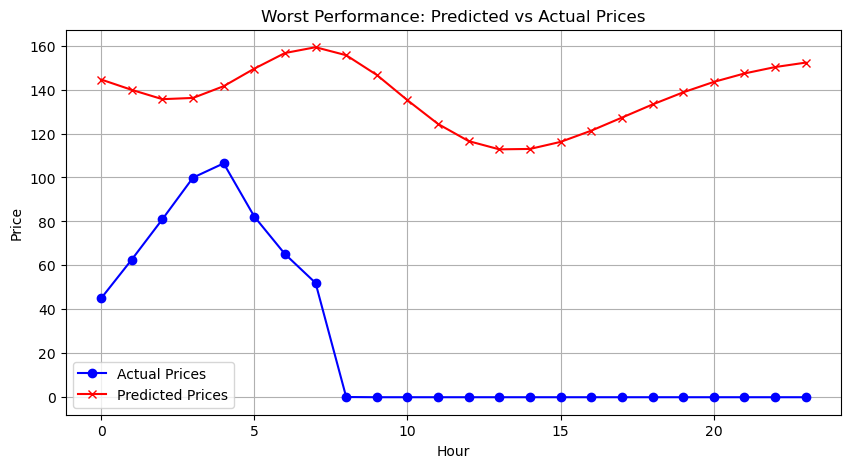

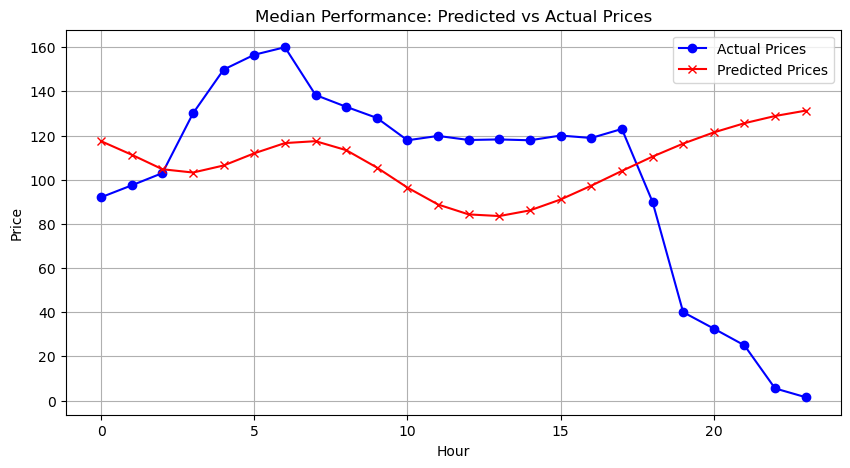

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function for inference with scaling applied
def decode_sequence(input_seq, encoder_model, decoder_model, scaler_y, n_features, n_timesteps_out):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first feature (Price1) as the start signal
    target_seq[0, 0, 0] = input_seq[0, -1, 0]  # Use the last price in the input sequence

    # Sampling loop
    decoded_seq = []
    for _ in range(n_timesteps_out):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Save prediction (output price in normalized range)
        decoded_seq.append(output_tokens[0, 0, 0])

        # Update the target sequence (use the predicted price as the next input)
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, 0] = output_tokens[0, 0, 0]

        # Update states
        states_value = [h, c]

    # Scale the predictions back to the original range
    decoded_seq = scaler_y.inverse_transform(np.array(decoded_seq).reshape(-1, 1)).flatten()
    return decoded_seq

# Generate predictions and visualize results
predictions = []
actuals = []

for i in range(100):  # Adjust the range to include more test samples
    input_seq = X_test[i:i+1]  # Single input sequence
    decoded_seq = decode_sequence(input_seq, encoder_model, decoder_model, scaler_y, n_features, n_timesteps_out)

    # Extract the actual sequence from `y_test`
    actual_seq = y_test[i * n_timesteps_out:(i + 1) * n_timesteps_out]
    actual_seq = scaler_y.inverse_transform(actual_seq.reshape(-1, 1)).flatten()  # Scale back

    predictions.append(decoded_seq)
    actuals.append(actual_seq)

# Convert predictions and actuals to arrays
y_test_pred = np.array(predictions)
y_test_actual = np.array(actuals)

# Calculate deviation metrics
deviation_x = np.abs(y_test_pred - y_test_actual)  # Absolute deviation
deviation_x2 = deviation_x ** 2  # Squared deviation

# Calculate total deviation for each example
total_deviation_x = deviation_x.sum(axis=1)
total_deviation_x2 = deviation_x2.sum(axis=1)

# Find indices for best, median, and worst performance
best_index = np.argmin(total_deviation_x)
worst_index = np.argmax(total_deviation_x)
median_index = np.argsort(total_deviation_x)[len(total_deviation_x) // 2]

# Visualize best, worst, and median results
def plot_prediction(index, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[index], label="Actual Prices", color="blue", marker='o')
    plt.plot(y_test_pred[index], label="Predicted Prices", color="red", marker='x')
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

print("### Visualization of Predictions ###")
plot_prediction(best_index, "Best Performance: Predicted vs Actual Prices")
plot_prediction(worst_index, "Worst Performance: Predicted vs Actual Prices")
plot_prediction(median_index, "Median Performance: Predicted vs Actual Prices")

